Шахниязов Ботир  
М8О-401Б-18  
Набор данных по оттоку клиентов телекоммуникационной компании  
https://www.kaggle.com/mnassrib/telecom-churn-datasets

In [1]:
%matplotlib inline
%pip install plotly

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from collections import Counter

from sklearn.ensemble import RandomForestClassifier as SklearnRFC
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.neighbors import KNeighborsClassifier as SklearnKNN
from sklearn.linear_model import LogisticRegression as SklearnLR

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
np.random.seed(17)

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
Number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
Total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
Total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
Total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
Total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


In [5]:
print(f'There are {df.isnull().any().sum()} columns in dataset with missing values.')
print(f'There are {len([col for col in df.columns if df[col].nunique() <= 1])} columns in dataset with one unique value.')

There are 0 columns in dataset with missing values.
There are 0 columns in dataset with one unique value.


# Обзор данных

In [6]:
lab = df["Churn"].value_counts().keys().tolist()
val = df["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Churn distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

There are 51 states


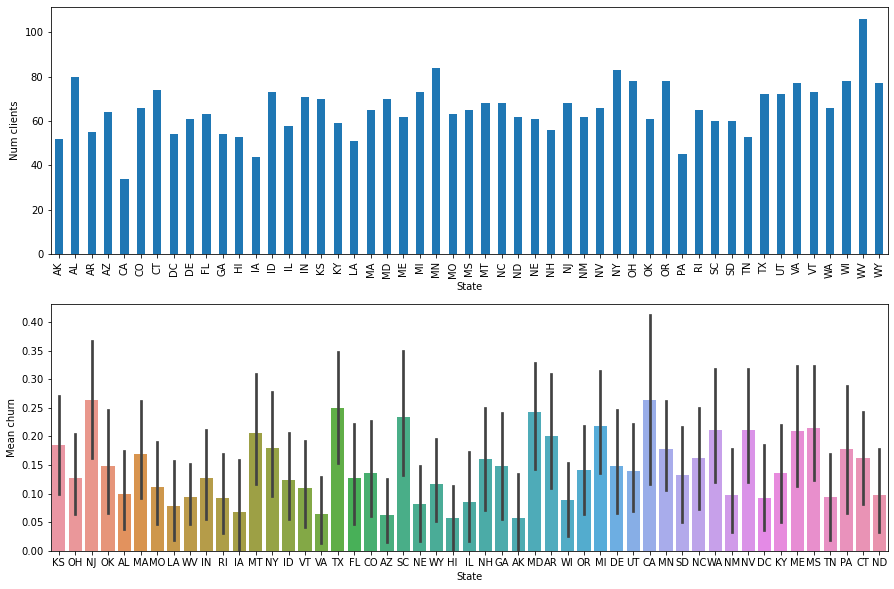

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

print(f"There are {df['State'].nunique()} states")
      
_, axes = plt.subplots(2, 1)
plt.subplot(211)
axes[0] = df.groupby('State').size().plot(kind='bar').set_ylabel('Num clients')
plt.subplot(212)
sns.barplot(x ='State', y = 'Churn', data=df).set_ylabel("Mean churn")
plt.show()

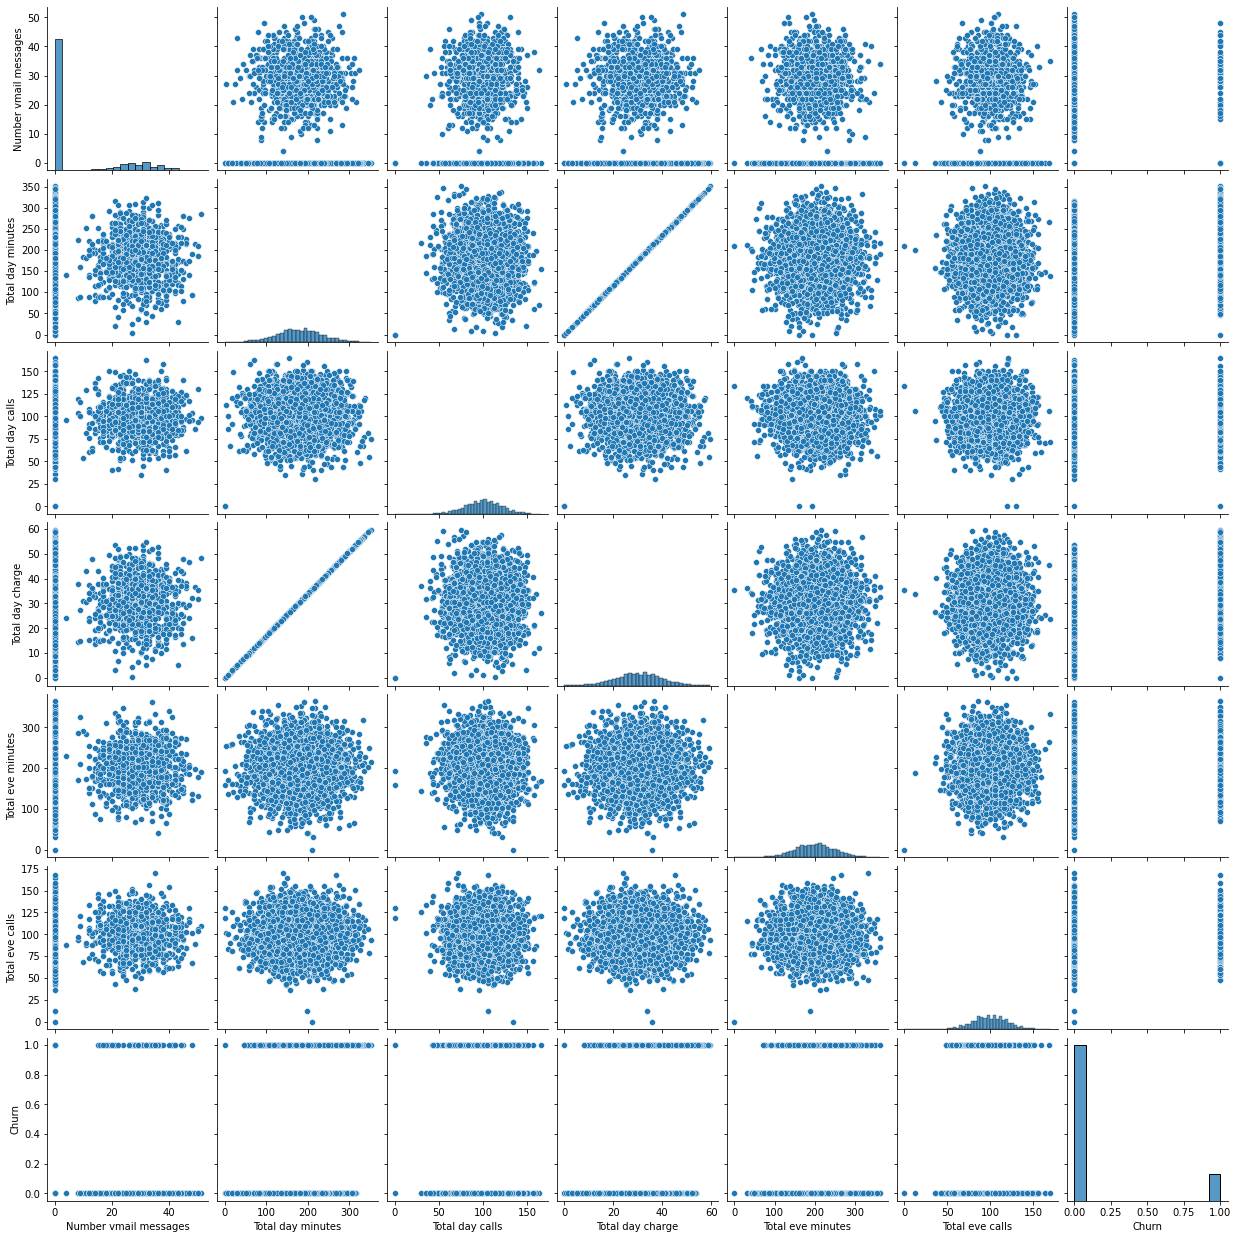

In [8]:
cols = ['Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Churn']
df['Churn'] = df['Churn'].apply(int)
sns.pairplot(df[cols])
plt.show()

# Подготовка данных

In [9]:
df.nunique()

State                       51
Account length             212
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       46
Total day minutes         1667
Total day calls            119
Total day charge          1667
Total eve minutes         1611
Total eve calls            123
Total eve charge          1440
Total night minutes       1591
Total night calls          120
Total night charge         933
Total intl minutes         162
Total intl calls            21
Total intl charge          162
Customer service calls      10
Churn                        2
dtype: int64

In [10]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [11]:
from sklearn.preprocessing import StandardScaler

df['International plan'] = df['International plan'].map({"No": 0, "Yes": 1})
df['Voice mail plan'] = df['Voice mail plan'].map({"No": 0, "Yes": 1})
df = pd.get_dummies(df, columns=['State', 'Area code'])

features_to_scale = ['Number vmail messages', 'Total day minutes',
                     'Total day calls', 'Total day charge', 'Total eve minutes',
                     'Total eve calls', 'Total eve charge', 'Total night minutes',
                     'Total night calls', 'Total night charge', 'Total intl minutes',
                     'Total intl calls', 'Total intl charge', 'Customer service calls'
                    ]
df[features_to_scale] = StandardScaler().fit_transform(df[features_to_scale]) # for linear models
df.drop(['Account length'], inplace=True, axis=1) #seems to be useless
print(df.shape)
df.head()

(3333, 71)


,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510
0,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,...,0,0,0,0,0,0,0,0,1,0
2,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,...,0,0,0,0,0,0,0,0,1,0
3,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,...,0,0,0,0,0,0,0,1,0,0
4,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,...,0,0,0,0,0,0,0,0,1,0


In [12]:
X, y = df.drop(['Churn'], axis=1), df['Churn']

In [13]:
X.head()

,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510
0,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,...,0,0,0,0,0,0,0,0,1,0
2,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,...,0,0,0,0,0,0,0,0,1,0
3,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,...,0,0,0,0,0,0,0,1,0,0
4,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,...,0,0,0,0,0,0,0,0,1,0


In [14]:
def cv_score(clf, X, y, k_folds=5, average='macro'):
    kf = StratifiedKFold(n_splits=k_folds, random_state=123, shuffle=True)
    scores = np.zeros(k_folds)    
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        # numpy required in case of algos realisation
        X_train, y_train = X.loc[train_index].to_numpy(), y.loc[train_index].to_numpy()
        X_val, y_val = X.loc[val_index].to_numpy(), y.loc[val_index].to_numpy()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        scores[i] = f1_score(y_val, y_pred, average=average)
    return scores

# Логистическая регрессия

In [15]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000):
        self.lr = lr
        self.num_iter = num_iter

    def getIntercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = self.getIntercept(X)
        self.coef_ = np.zeros(X.shape[1])  # weights

        for _ in range(self.num_iter):
            z = np.dot(X, self.coef_)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.coef_ -= self.lr * gradient

    def predict(self, X):
        X = self.getIntercept(X)
        return self.sigmoid(np.dot(X, self.coef_)).round()

In [16]:
%%time
lr = LogisticRegression()
scores = cv_score(lr, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.51 (+/- 0.02)
Wall time: 560 ms


In [17]:
%%time
s_lr = SklearnLR()
scores = cv_score(s_lr, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.61 (+/- 0.03)
Wall time: 216 ms


# Дерево решений

In [18]:
class Node():
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier():
    def __init__(self, max_depth=1, rf=False):
        self.max_depth = max_depth
        self.rf = rf

    def fit(self, X, y, max_features=None):
        self.n_classes_ = len(set(y))
        if not self.rf:
            n_features_ = X.shape[1]
        else:
            # bootstrap X for single tree
            bs_ids = np.random.choice(X.shape[0], X.shape[0])
            X, y = X[tuple([bs_ids])], y[tuple([bs_ids])]
            if max_features is None:
                # default for classification
                n_features_ = np.sqrt(X.shape[1]).astype(int)
            else:
                n_features_ = max_features
        self.features_ = np.sort(np.random.choice(X.shape[1], n_features_,
                                                  replace=False))
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in self.features_:
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i)
                                 for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [19]:
%%time
dtc = DecisionTreeClassifier(max_depth=5)
scores = cv_score(dtc, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.86 (+/- 0.04)
Wall time: 23.3 s


In [20]:
%%time
s_dtc = SklearnDTC(max_depth=5)
scores = cv_score(s_dtc, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.86 (+/- 0.04)
Wall time: 93.8 ms


# Случайный лес

In [21]:
class RandomForestClassifier():
    def __init__(self, max_depth=5, n_estimators=100, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.forest = [None] * n_estimators

    def fit(self, X, y):
        for i in range(self.n_estimators):
            self.forest[i] = DecisionTreeClassifier(
                self.max_depth, rf=True)
            self.forest[i].fit(X, y)
            #print(f'Tree:{i+1}, {self.forest[i].features_}')

    def predict(self, X):
        most_common = np.zeros(X.shape[0])
        preds = np.zeros((self.n_estimators, X.shape[0]))
        for i in range(self.n_estimators):
            preds[i] = self.forest[i].predict(X)
        for i in range(len(most_common)):
            most_common[i] = Counter(preds[:, i]).most_common(1)[0][0]
        return most_common.astype(int)

In [22]:
%%time
rf = RandomForestClassifier()
scores = cv_score(rf, X, y)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.46 (+/- 0.00)
Wall time: 4min 35s


In [23]:
%%time
s_rf = SklearnRFC()
scores = cv_score(s_rf, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.86 (+/- 0.05)
Wall time: 2.21 s
